In [37]:
from typing import Annotated
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import RemoveMessage, HumanMessage
from langgraph.checkpoint.memory import MemorySaver
import os

In [38]:
os.environ['GROQ_API_KEY'] = "xxxxx"

In [39]:
class State(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder = StateGraph(State)

In [40]:
groq_llm = ChatGroq(model="llama3-70b-8192", temperature=0)

In [41]:
# Define the tools for the agent to use
@tool
def search(query: str):
    """Call to check the weather"""
    return "the weather is pleasant with 24 degrees."

In [42]:
tools = [search]

tool_node = ToolNode(tools)

In [43]:
agent = groq_llm.bind_tools(tools)

In [44]:
def should_continue(state: State) -> Literal[END, "tools"]: # type: ignore
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [45]:
def generate(state: State):
    messages = state['messages']
    response = groq_llm.invoke(messages)
    print(response)
    return {"messages": response}

In [46]:
def my_node_2(state: State):
    # keep most recent messages in memory
    n = 4
    delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-n]]
    return {"messages": delete_messages}

In [47]:
def call_model(state: State):
    messages = state['messages']
    response = agent.invoke(messages)
    return {"messages": messages + [response]}

In [48]:
memory = MemorySaver()

In [49]:
builder = StateGraph(State)
builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)
builder.add_node("node", my_node_2)

builder.add_edge(START, "node")
builder.add_edge("node", "agent")
builder.add_conditional_edges(
    "agent",
    should_continue,
)
builder.add_edge("tools", "agent")
graph = builder.compile(checkpointer=memory)

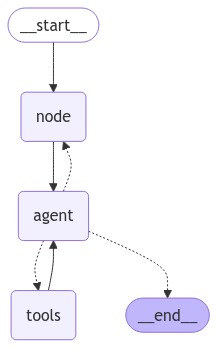

In [57]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [50]:
def bot(question, id):
    inputs = {"messages": [HumanMessage(content=question)]}
    config = {"configurable": {"thread_id": id}}
    for msg, metadata in graph.stream(inputs, stream_mode="messages", config=config):
        if (
            msg.content
            and not isinstance(msg, HumanMessage)
            and metadata["langgraph_node"] == "agent"
        ):
            print(msg.content, end='', flush=True)

In [60]:
bot("who created you?", "1")

I was created by a group of researcher at Meta AI.Hello Saif, I'm your assistant, nice to meet you!Likewise, Saif! Is there anything I can help you with or would you like to chat about something in particular?

In [61]:
memory.get(config={"configurable": {"thread_id": "1"}})['channel_values']['messages']

[AIMessage(content="Hello Saif, I'm your assistant, nice to meet you!", response_metadata={'finish_reason': 'stop'}, id='run-e6b9bb15-3958-41b8-9274-c91df6536f22', usage_metadata={'input_tokens': 1001, 'output_tokens': 15, 'total_tokens': 1016}),
 HumanMessage(content='nice to meet you', id='810dcac1-b6ef-4307-89b3-0d01d44006a7'),
 AIMessage(content='Likewise, Saif! Is there anything I can help you with or would you like to chat about something in particular?', response_metadata={'finish_reason': 'stop'}, id='run-6d35cb47-040c-4079-988b-e71a1f7e84d6', usage_metadata={'input_tokens': 956, 'output_tokens': 26, 'total_tokens': 982}),
 HumanMessage(content='who created you?', id='0fff6e4d-cf47-4048-9e72-37120349588b'),
 AIMessage(content='I was created by a group of researcher at Meta AI.', response_metadata={'finish_reason': 'stop'}, id='run-46738501-9b50-4271-8598-655e8d68cdd6', usage_metadata={'input_tokens': 964, 'output_tokens': 13, 'total_tokens': 977})]